# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 1, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 1,#int or None
        'neg_d_prob': 0.2,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 7,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 5
[[0], [1], [2], [3], [-1]]


  0%|          | 0/5 [00:00<?, ?it/s]

List length: 5
[[0], [1], [2], [3], [-1]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_30_drop0.25e500b256_custom/lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_laurent_negd_1_prob_0.2_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_laurent_negd_1_prob_0.2_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=7)]: Using backend MultiprocessingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.4min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
33553,1373158606,0.110,0.904,0.347,-0.851,0.000,0.130,0.649,0.837,-1.094,0.004,0.110,0.904,0.347,-0.851,0.000,-0.010,-0.248,0.312,0.267,0.296,0.251,0.344,-0.324,0.247,0.525,0.414,-0.096,-0.021,0.354,0.282,0.394,0.153,0.410,0.335,0.388,0.301,0.048,0.010,-0.046,-0.441,0.000,0.000,-0.229,-0.193,-0.032,-0.028,-0.210,0.000,-0.184,-0.056,-0.251,0.000,0.000,-0.218,-0.030,-0.245,-0.015,-0.043,-0.039,-0.042,-0.034,-0.049,-0.024,0.000,0.000,-0.278,-0.392,-0.510,-0.621,0.271,0.319,-0.389,-0.445,-0.700,0.155,-0.291,-0.385,-0.397,-0.356,0.280,-0.382,0.536,0.198,0.264,0.208,0.260,-0.340,-0.050,-0.285,-0.418,0.243
9427,1373158606,-0.294,0.859,-0.018,-0.458,0.000,-0.324,1.037,-0.447,-0.157,0.003,-0.294,0.859,-0.018,-0.458,-0.000,-0.010,-0.248,0.156,-0.230,0.203,0.153,0.203,-0.324,-0.374,0.402,0.358,-0.096,-0.021,0.249,0.179,0.286,0.063,0.314,0.255,0.302,0.173,0.351,0.010,-0.046,-0.441,0.000,0.000,-0.099,0.116,-0.021,-0.014,0.005,0.000,0.149,-0.031,-0.027,0.000,0.000,-0.016,-0.016,-0.019,-0.005,-0.025,-0.023,-0.027,-0.014,-0.255,-0.026,0.000,0.000,-0.278,-0.392,-0.205,-0.418,0.158,0.212,0.064,-0.445,-0.727,0.072,0.066,-0.385,-0.397,0.079,0.171,0.087,0.462,0.091,0.147,0.103,0.164,-1.187,-0.049,-0.285,-0.418,-0.083
199,1373158606,0.000,0.000,-0.124,0.000,-0.588,-2.434,10.741,-17.272,8.838,-0.419,-0.000,0.000,-0.124,0.000,-0.588,-0.010,-0.248,-0.952,-1.971,0.306,0.272,-1.315,-0.324,-2.480,-1.824,-0.768,-0.096,-0.021,-0.892,0.292,-0.650,0.009,0.470,0.349,0.420,0.289,-3.153,-4.373,-0.046,-0.441,0.000,0.000,0.404,0.433,-0.135,-0.148,0.449,0.000,0.427,0.494,0.434,0.000,0.000,0.446,-0.147,0.432,-0.025,-0.233,-0.172,-0.211,-0.144,0.476,0.533,0.000,0.000,-0.278,-0.392,-1.413,-2.751,0.310,0.463,-1.612,-0.445,-3.497,-1.771,-0.895,-0.385,-0.397,-1.160,0.358,-0.890,0.430,0.229,0.293,0.245,0.340,-4.583,-5.191,-0.285,-0.418,-1.059
12447,1373158606,-0.145,0.000,0.000,0.000,0.000,-0.145,0.002,-0.006,0.004,0.000,-0.145,0.000,-0.000,0.000,0.000,-0.010,-0.248,0.127,0.049,0.121,0.079,0.146,-0.324,0.027,0.275,0.319,-0.096,-0.021,0.185,0.080,0.212,0.023,0.251,0.170,0.234,0.042,-0.006,-0.054,-0.046,-0.441,0.000,0.000,-0.111,-0.046,-0.090,-0.075,-0.014,0.000,-0.026,0.050,-0.037,0.000,0.000,-0.034,-0.061,-0.154,-0.028,-0.041,-0.146,-0.069,-0.027,-0.000,0.005,0.000,0.000,-0.278,-0.392,-0.191,-0.208,0.103,0.174,-0.000,-0.445,-0.245,-0.001,0.001,-0.385,-0.397,0.000,0.088,-0.085,0.443,0.000,0.137,-0.001,0.033,-0.316,-0.066,-0.285,-0.418,-0.145
39489,1373158606,0.884,-0.248,0.000,-0.571,0.357,3.564,-10.730,15.290,-7.919,0.153,0.884,-0.248,-0.000,-0.571,0.357,-0.010,-0.248,0.338,0.264,-0.371,-0.369,0.423,-0.324,0.270,-0.872,0.507,-0.096,-0.021,0.418,-1.462,0.448,-2.703,-0.433,-0.359,-0.409,-2.583,0.221,0.010,-0.046,-0.441,0.000,0.000,-0.127,-0.097,0.332,0.325,-0.156,0.000,-0.126,0.421,-0.159,0.000,0.000,-0.144,0.537,-0.159,0.419,0.397,0.326,0.368,0.561,-0.086,-0.024,0.000,0.000,-0.278,-0.392,-0.368,-0.445,0.497,0.553,-0.290,-0.445,-0.607,0.515,-0.204,-0.385,-0.397,-0.247,2.007,-0.264,4.056,0.405,0.490,0.412,3.100,-0.676,-0.049,-0.285,-0.418,1.166


In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,1373158606.000,-0.001,0.002,0.001,0.000,-0.000,-0.012,0.064,-0.096,0.045,-0.000,-0.001,0.002,0.001,0.000,-0.000,-0.010,-0.248,0.128,0.009,0.114,0.022,0.142,-0.324,-0.038,0.186,0.352,-0.096,-0.021,0.218,0.026,0.275,-0.206,0.273,0.207,0.262,-0.122,-0.121,-0.229,-0.046,-0.441,0.000,0.000,-0.049,-0.018,-0.032,-0.019,-0.023,0.000,-0.015,0.031,-0.053,0.000,0.000,-0.028,-0.010,-0.058,0.021,-0.043,-0.058,-0.037,0.018,-0.001,0.041,0.000,0.000,-0.278,-0.392,-0.352,-0.485,0.306,0.448,-0.201,-0.445,-0.578,0.056,-0.084,-0.385,-0.397,-0.144,0.371,-0.178,0.899,0.100,0.264,0.129,0.465,-0.721,-0.502,-0.285,-0.418,0.007
std,0.000,0.505,0.486,0.486,0.489,0.246,1.505,5.908,9.132,4.624,0.145,0.505,0.486,0.486,0.489,0.246,0.000,0.000,0.347,0.512,0.378,0.506,0.463,0.000,0.615,0.727,0.293,0.000,0.000,0.329,0.543,0.295,0.934,0.370,0.290,0.326,0.895,0.782,1.072,0.000,0.000,0.000,0.000,0.167,0.160,0.168,0.165,0.183,0.000,0.161,0.273,0.194,0.000,0.000,0.177,0.167,0.170,0.163,0.216,0.173,0.186,0.189,0.163,0.184,0.000,0.000,0.000,0.000,0.365,0.588,0.403,0.568,0.490,0.000,0.739,0.643,0.304,0.000,0.000,0.351,0.599,0.298,1.202,0.398,0.306,0.350,0.985,0.984,1.212,0.000,0.000,0.554
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-11.007,-40.329,-60.902,-30.798,-0.827,-1.000,-1.000,-1.000,-1.000,-1.000,-0.010,-0.248,-4.939,-4.520,-4.361,-4.239,-4.508,-0.324,-4.040,-4.210,-2.810,-0.096,-0.021,-4.519,-4.084,-5.257,-6.754,-1.815,-4.417,-3.023,-5.372,-4.728,-7.402,-0.046,-0.441,0.000,0.000,-0.605,-0.415,-0.548,-0.453,-0.805,0.000,-0.442,-0.946,-0.913,0.000,0.000,-0.783,-0.390,-0.666,-0.411,-0.893,-0.668,-0.821,-0.545,-0.486,-0.530,0.000,0.000,-0.278,-0.392,-5.867,-5.500,-1.349,-0.959,-5.028,-0.445,-5.540,-2.448,-2.668,-0.385,-0.397,-4.608,-1.358,-5.835,0.131,-1.560,-1.348,-1.565,-2.898,-6.683,-9.035,-0.285,-0.418,-3.199
25%,1373158606.000,-0.352,-0.288,-0.290,-0.298,0.000,-0.451,-0.450,-0.633,-0.301,-0.003,-0.352,-0.288,-0.290,-0.298,-0.000,-0.010,-0.248,0.102,0.033,0.087,0.012,0.135,-0.324,0.030,0.227,0.327,-0.096,-0.021,0.190,0.048,0.243,-0.004,0.243,0.147,0.229,0.009,0.026,0.008,-0.046,-0.441,0.000,0.000,-0.146,-0.094,-0.125,-0.097,-0.119,0.000,-0.082,-0.121,-0.161,0.000,0.000,-0.135,-0.088,-0.173,-0.025,-0.141,-0.166,-0.144,-0.047,-0.052,-0.024,0.000,0.000,-0.278,-0.392,-0.423,-0.457,0.127,0.202,-0.253,-0.445,-0.512,-0.132,-0.207,-0.385,-0.397,-0.244,0.131,-0.288,0.430,-0.006,0.106,-0.001,0.054,-0.618,-0.3

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.46090259],
       [0.10577573],
       [0.9130468 ],
       [0.49852098],
       [0.78355729],
       [0.70730873],
       [0.21320786],
       [0.57263504],
       [0.62688689],
       [0.53872974]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.5166591 ],
       [0.20806498],
       [0.57668708],
       [0.54108354],
       [0.62168377],
       [0.6215422 ],
       [0.30984831],
       [0.5812829 ],
       [0.60306484],
       [0.56428691]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 92)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 92)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 92)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
9901,1373158606,0.000,0.796,0.164,-0.157,0.000,-0.063,1.027,-0.198,0.043,0.006,0.000,0.796,0.164,-0.157,-0.000,-0.010,-0.248,0.161,0.089,0.309,0.261,0.141,-0.324,0.074,0.548,0.367,-0.096,-0.021,0.172,0.285,0.229,0.152,0.415,0.395,0.395,0.300,0.045,0.010,-0.046,-0.441,0.000,0.000,-0.120,-0.089,-0.037,-0.031,-0.099,0.000,-0.075,-0.062,-0.027,0.000,0.000,-0.113,-0.033,-0.155,-0.017,-0.049,-0.052,-0.047,-0.033,-0.051,-0.024,0.000,0.000,-0.278,-0.392,-0.214,-0.245,0.283,0.332,-0.043,-0.445,-0.283,0.155,0.083,-0.385,-0.397,-0.036,0.287,-0.092,0.555,0.203,0.322,0.213,0.279,-0.339,-0.049,-0.285,-0.418,0.097
5910,1373158606,0.000,-0.421,-0.211,-0.123,0.000,0.023,-0.447,-0.267,-0.047,-0.003,-0.000,-0.421,-0.211,-0.123,0.000,-0.010,-0.248,0.344,0.203,0.080,0.044,0.316,-0.324,0.231,0.469,0.425,-0.096,-0.021,0.337,0.045,0.369,0.010,0.373,0.125,0.352,0.036,0.242,0.222,-0.046,-0.441,0.000,0.000,-0.174,-0.025,-0.080,-0.046,-0.041,0.000,-0.075,-0.059,-0.054,0.000,0.000,-0.043,-0.046,-0.062,-0.025,-0.047,-0.125,-0.045,-0.041,-0.165,-0.033,0.000,0.000,-0.278,-0.392,-0.439,-0.298,0.085,0.152,-0.191,-0.445,-0.415,-0.128,-0.144,-0.385,-0.397,-0.182,0.072,-0.183,0.431,-0.161,0.091,-0.168,0.053,-0.746,-0.281,-0.285,-0.418,-0.057
18619,1373158606,0.350,-0.764,0.000,0.000,0.000,0.380,-0.829,0.025,0.027,-0.004,0.350,-0.764,0.000,-0.000,0.000,-0.010,-0.248,0.306,0.204,-0.037,-0.087,0.310,-0.324,0.175,0.445,0.427,-0.096,-0.021,0.334,-0.102,0.390,-0.249,0.282,0.119,0.229,-0.206,0.143,0.212,-0.046,-0.441,0.000,0.000,-0.125,-0.035,0.033,0.070,-0.043,0.000,-0.024,-0.049,-0.076,0.000,0.000,-0.041,0.081,-0.131,0.083,0.019,0.020,0.056,0.116,-0.018,-0.025,0.000,0.000,-0.278,-0.392,-0.356,-0.308,0.058,0.204,-0.189,-0.445,-0.337,-0.130,-0.146,-0.385,-0.397,-0.176,0.152,-0.243,0.786,-0.059,-0.030,-0.049,0.242,-0.409,-0.275,-0.285,-0.418,0.172
33312,1373158606,-0.424,0.603,-0.154,-0.562,0.000,-0.284,-0.027,-0.070,0.034,0.001,-0.424,0.603,-0.154,-0.562,-0.000,-0.010,-0.248,0.211,0.114,0.204,0.140,0.209,-0.324,0.079,0.315,0.373,-0.096,-0.021,0.251,0.148,0.329,0.013,0.275,0.266,0.285,0.080,0.029,-0.010,-0.046,-0.441,0.000,0.000,0.018,0.048,-0.021,-0.015,0.072,0.000,0.049,0.128,0.046,0.000,0.000,0.064,-0.013,0.013,-0.022,-0.025,-0.029,-0.025,-0.009,0.052,0.126,0.000,0.000,-0.278,-0.392,-0.230,-0.258,0.178,0.213,-0.114,-0.445,-0.292,-0.051,-0.103,-0.385,-0.397,-0.119,0.153,-0.156,0.431,0.070,0.186,0.104,0.079,-0.355,-0.180,-0.285,-0.418,-0.150
47430,1373158606,0.000,-0.476,0.356,0.887,0.000,0.061,-0.718,0.787,0.610,-0.006,-0.000,-0.476,0.356,0.887,0.000,-0.010,-0.248,0.090,-0.003,0.411,0.371,0.158,-0.324,-0.007,0.562,0.327,-0.096,-0.021,0.197,0.389,0.249,0.268,0.498,0.467,0.504,0.369,-0.004,0.008,-0.046,-0.441,0.000,0.000,-0.007,-0.005,-0.286,-0.263,0.013,0.000,0.009,-0.266,0.006,0.000,0.000,0.013,-0.255,-0.019,-0.189,-0.197,-0.254,-0.210,-0.221,-0.004,-0.026,0.000,0.000,-0.278,-0.392,-0.104,-0.172,0.553,0.621,0.005,-0.445,-0.221,0.269,0.001,-0.385,-0.397,0.000,0.551,-0.011,0.952,0.347,0.508,0.391,0.528,-0.306,-0.048,-0.285,-0.418,-0.072


In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
7038,1373158606,-0.403,0.013,-0.810,0.000,-0.344,-2.665,9.510,-15.423,7.375,-0.190,-0.403,0.013,-0.810,0.000,-0.344,-0.010,-0.248,-0.673,-0.989,0.201,-0.002,-0.906,-0.324,-1.217,-0.782,-0.106,-0.096,-0.021,-0.583,0.164,-0.444,0.010,0.631,0.245,0.569,0.038,-1.559,-3.896,-0.046,-0.441,0.000,0.000,0.266,0.287,-0.129,-0.002,0.313,0.000,0.305,0.352,0.151,0.000,0.000,0.299,-0.105,0.247,-0.024,-0.521,-0.157,-0.390,-0.042,0.317,0.589,0.000,0.000,-0.278,-0.392,-0.979,-1.435,-0.256,0.124,-1.020,-0.445,-1.804,-0.663,-0.005,-0.385,-0.397,-0.715,-0.254,-0.553,0.431,-0.631,-0.251,-0.686,0.054,-2.374,-4.413,-0.285,-0.418,-1.264
30770,1373158606,0.201,0.869,-0.438,-0.504,0.671,3.830,-14.551,23.484,-12.535,0.408,0.201,0.869,-0.438,-0.504,0.671,-0.010,-0.248,0.398,0.347,-0.937,-1.286,0.492,-0.324,0.328,-3.004,0.592,-0.096,-0.021,0.493,-1.917,0.514,-3.704,-0.754,-0.613,-0.776,-3.749,0.045,0.010,-0.046,-0.441,0.000,0.000,-0.227,-0.188,0.477,0.491,-0.276,0.000,-0.190,0.618,-0.322,0.000,0.000,-0.258,0.528,-0.290,0.529,0.436,0.371,0.437,0.585,-0.051,-0.024,0.000,0.000,-0.278,-0.392,-0.617,-0.814,1.343,1.896,-0.451,-0.445,-0.980,3.033,-0.413,-0.385,-0.397,-0.392,2.450,-0.462,5.423,0.707,0.753,0.841,4.418,-0.339,-0.049,-0.285,-0.418,1.640
41342,1373158606,0.000,0.000,-0.682,0.000,0.000,-0.025,0.182,-1.058,0.237,0.001,0.000,-0.000,-0.682,-0.000,0.000,-0.010,-0.248,0.333,0.268,0.084,0.045,0.309,-0.324,0.265,0.454,0.427,-0.096,-0.021,0.355,0.049,0.382,0.010,0.363,0.130,0.344,0.029,0.235,0.218,-0.046,-0.441,0.000,0.000,-0.160,-0.119,-0.086,-0.048,-0.044,0.000,-0.160,-0.055,-0.078,0.000,0.000,-0.114,-0.050,-0.120,-0.026,-0.046,-0.130,-0.043,-0.038,-0.168,-0.053,0.000,0.000,-0.278,-0.392,-0.398,-0.420,0.099,0.159,-0.178,-0.445,-0.587,-0.122,-0.145,-0.385,-0.397,-0.226,0.084,-0.206,0.430,-0.147,0.104,-0.159,0.044,-0.761,-0.306,-0.285,-0.418,-0.011
21084,1373158606,-0.338,0.347,-0.202,0.000,0.432,1.422,-7.252,11.856,-6.213,0.303,-0.338,0.347,-0.202,-0.000,0.432,-0.010,-0.248,0.271,0.231,-1.275,-1.639,0.333,-0.324,0.194,0.463,0.430,-0.096,-0.021,0.351,-2.198,0.367,-3.131,-1.118,-0.667,-0.880,-3.198,0.166,0.010,-0.046,-0.441,0.000,0.000,-0.112,-0.109,0.394,0.388,-0.155,0.000,-0.093,-0.191,-0.181,0.000,0.000,-0.167,0.400,-0.153,0.416,0.449,0.398,0.421,0.455,-0.077,-0.024,0.000,0.000,-0.278,-0.392,-0.284,-0.373,1.649,2.228,-0.247,-0.445,-0.428,-0.159,-0.172,-0.385,-0.397,-0.243,2.774,-0.195,4.761,1.255,0.984,1.057,3.839,-0.517,-0.049,-0.285,-0.418,0.617
47211,1373158606,-0.481,0.000,0.000,0.000,0.000,-0.482,0.004,-0.008,0.004,-0.000,-0.481,0.000,-0.000,0.000,-0.000,-0.010,-0.248,0.036,0.000,0.120,0.091,0.094,-0.324,0.001,0.189,0.305,-0.096,-0.021,0.151,0.080,0.239,0.011,0.251,0.173,0.226,0.051,-0.005,-0.094,-0.046,-0.441,0.000,0.000,-0.008,-0.003,-0.120,-0.092,0.068,0.000,-0.002,0.167,0.085,0.000,0.000,0.072,-0.071,0.029,-0.024,-0.040,-0.174,-0.089,-0.033,-0.002,0.064,0.000,0.000,-0.278,-0.392,-0.112,-0.208,0.150,0.209,-0.001,-0.445,-0.256,-0.000,-0.000,-0.385,-0.397,-0.000,0.096,-0.000,0.431,-0.001,0.195,0.001,0.043,-0.320,-0.043,-0.285,-0.418,-0.479


In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
35587,1373158606,-0.707,-0.190,0.000,0.059,0.000,-0.718,-0.100,-0.176,0.159,0.000,-0.707,-0.190,-0.000,0.059,0.000,-0.010,-0.248,0.139,0.050,0.157,0.124,0.141,-0.324,0.018,0.211,0.326,-0.096,-0.021,0.192,0.131,0.281,0.010,0.226,0.218,0.228,0.039,-0.026,-0.114,-0.046,-0.441,0.000,0.000,0.094,0.106,-0.146,-0.125,0.166,0.000,0.110,0.262,0.154,0.000,0.000,0.158,-0.093,0.114,-0.024,-0.134,-0.170,-0.141,-0.041,0.116,0.219,0.000,0.000,-0.278,-0.392,-0.225,-0.287,0.217,0.281,-0.158,-0.445,-0.337,-0.101,-0.119,-0.385,-0.397,-0.150,0.176,-0.153,0.430,0.067,0.230,0.101,0.054,-0.427,-0.292,-0.285,-0.418,-0.396
32681,1373158606,0.000,0.000,-0.293,0.000,0.000,-0.015,0.107,-0.507,0.131,0.000,0.000,0.000,-0.293,0.000,-0.000,-0.010,-0.248,0.219,0.174,0.095,0.063,0.229,-0.324,0.166,0.368,0.365,-0.096,-0.021,0.262,0.061,0.312,-0.002,0.285,0.139,0.255,0.016,0.121,0.128,-0.046,-0.441,0.000,0.000,-0.117,-0.122,-0.095,-0.064,-0.030,0.000,-0.094,-0.046,-0.062,0.000,0.000,-0.072,-0.063,-0.120,-0.005,-0.035,-0.139,-0.043,-0.017,-0.051,-0.029,0.000,0.000,-0.278,-0.392,-0.251,-0.387,0.116,0.177,-0.103,-0.445,-0.411,-0.066,-0.076,-0.385,-0.397,-0.117,0.105,-0.137,0.423,-0.083,0.122,-0.075,0.033,-0.408,-0.222,-0.285,-0.418,-0.005
40971,1373158606,0.548,-0.428,0.318,-0.586,0.000,0.445,0.205,-0.926,0.169,0.002,0.548,-0.428,0.318,-0.586,-0.000,-0.010,-0.248,0.297,0.232,0.029,-0.066,0.317,-0.324,0.209,0.456,0.456,-0.096,-0.021,0.343,-0.066,0.398,-0.156,0.126,0.124,0.144,-0.192,0.175,0.014,-0.046,-0.441,0.000,0.000,-0.173,-0.151,0.105,0.102,-0.091,0.000,-0.136,-0.065,-0.121,0.000,0.000,-0.121,0.117,-0.166,0.147,0.154,0.093,0.135,0.182,-0.117,-0.021,0.000,0.000,-0.278,-0.392,-0.391,-0.445,0.146,0.246,-0.217,-0.445,-0.487,-0.103,-0.209,-0.385,-0.397,-0.226,0.197,-0.285,0.708,0.058,0.116,0.062,0.306,-0.572,-0.052,-0.285,-0.418,0.243
21022,1373158606,-0.791,0.000,0.772,-0.133,0.000,-0.734,-0.152,0.985,-0.267,-0.004,-0.791,0.000,0.772,-0.133,-0.000,-0.010,-0.248,-0.109,-0.135,0.320,0.283,-0.159,-0.324,-0.156,-0.204,0.184,-0.096,-0.021,-0.119,0.273,0.115,0.017,0.401,0.366,0.382,0.254,-0.189,-0.333,-0.046,-0.441,0.000,0.000,0.097,0.109,-0.205,-0.191,0.143,0.000,0.119,0.191,0.172,0.000,0.000,0.123,-0.157,0.134,-0.020,-0.179,-0.250,-0.196,-0.114,0.126,0.216,0.000,0.000,-0.278,-0.392,-0.213,-0.328,0.422,0.510,-0.165,-0.445,-0.407,-0.069,-0.009,-0.385,-0.397,-0.088,0.368,-0.012,0.434,0.240,0.443,0.270,0.314,-0.541,-0.420,-0.285,-0.418,-0.518
6403,1373158606,0.203,0.000,-0.079,0.000,0.000,0.197,0.025,-0.118,0.023,0.000,0.203,-0.000,-0.079,-0.000,-0.000,-0.010,-0.248,0.176,0.102,0.098,0.032,0.181,-0.324,0.085,0.289,0.330,-0.096,-0.021,0.215,0.048,0.275,-0.055,0.233,0.163,0.226,-0.044,0.064,0.010,-0.046,-0.441,0.000,0.000,-0.101,-0.053,-0.036,-0.023,-0.052,0.000,-0.067,-0.044,-0.090,0.000,0.000,-0.067,-0.007,-0.118,0.030,0.041,-0.087,0.011,0.030,-0.041,-0.024,0.000,0.000,-0.278,-0.392,-0.211,-0.222,0.102,0.170,-0.050,-0.445,-0.286,-0.007,-0.037,-0.385,-0.397,-0.052,0.095,-0.113,0.467,-0.000,0.123,0.004,0.075,-0.344,-0.050,-0.285,-0.418,0.188


## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   10.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   15.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   22.7s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   33.5s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:   46.9s
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed:  2.2min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done 9786 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 11236 tasks      | elapsed:  5.8mi

Training Time: 1:23:49
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:20
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
'symbolic_regression_functions'
EXIT symbolic_regression_functions
<class 'KeyError'>
FV Calculation Time: 0:02:03
-----------------

Traceback (most recent call last):
  File "../utilities/InterpretationNet.py", line 1076, in calculate_all_function_values
    function_values = parallel_fv_calculation_from_sympy(polynomial_dict['symbolic_regression_functions'], lambda_net_dataset.X_test_data_list, n_jobs_parallel_fv=n_jobs_parallel_fv, backend=backend)
KeyError: 'symbolic_regression_functions'


lambda_preds_VS_lstsq_target_polynomials
[[-0.74606526 -0.8045759  -0.82474697 ... -0.764819   -0.7536571
  -0.72799575]
 [-0.07927614 -0.01115462 -0.13182972 ... -0.1442927  -0.20462015
  -0.2559951 ]
 [ 0.4178292   0.31792918  0.41611654 ...  0.0274841  -0.00725292
  -0.08252878]
 ...
 [ 0.16686809  0.264584    0.28909203 ...  0.31235453  0.21491697
   0.26967895]
 [-0.681883   -1.199881   -1.1376551  ... -1.3202513  -0.49726167
  -1.6178875 ]
 [-0.24823813 -0.27083433 -0.14476247 ... -0.18066289 -0.18019573
  -0.28285837]]
[[-0.74886024 -0.8064432  -0.824663   ... -0.7692596  -0.7572783
  -0.72818893]
 [-0.08284181 -0.01149625 -0.13202016 ... -0.144784   -0.20379889
  -0.26198474]
 [ 0.41561273  0.32065246  0.4137052  ...  0.02746098 -0.01669207
  -0.13625695]
 ...
 [ 0.16836533  0.27078757  0.29184404 ...  0.30684695  0.19809847
   0.28110248]
 [-0.67943543 -1.1868434  -1.1286821  ... -1.307871   -0.4971349
  -1.657988  ]
 [-0.2509656  -0.27381116 -0.14361393 ... -0.18108682 -0.180

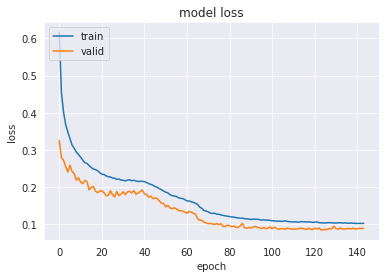

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials'])

In [25]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [26]:
poly_optimize

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([0.        , 1.        , 2.        , 3.        , 4.        ,
       0.01165623, 0.03168492, 0.08612854, 0.23412165, 0.6364086 ,
       0.01165623, 0.03168492, 0.08612854, 0.23412165, 0.6364086 ,
       0.01165623, 0.03168492, 0.08612854, 0.23412165, 0.6364086 ,
       0.01165623, 0.03168492, 0.08612854, 0.23412165, 0.6364086 ,
       0.01165623, 0.03168492, 0.08612854, 0.23412165, 0.6364086 ],
      dtype=float32)>

In [27]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [28]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 76)]         0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          39424       input[0][0]                      
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
hidden2_1024 (Dense)            (None, 1024)         525312      dropout1_0.25[0][0]              
______________________________________________________________________________________________

In [29]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [30]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.028,0.071,0.082,0.452,0.164,0.885,0.069,-0.023,-0.027,1.100,1.184
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.016,0.023,0.055,0.974,0.056,0.231,0.023,-0.023,-0.023,1.100,1.103
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.028,0.071,0.082,0.452,0.164,0.885,0.069,-0.023,-0.027,1.100,1.184
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.090,0.117,0.447,0.436,0.359,0.661,0.091,-0.023,-0.048,1.100,1.234
target_polynomials_VS_lstsq_lambda_pred_polynomials,1.473,5.018,39.843,0.402,0.110,0.031,0.064,0.105,-3463401103.817,inf,inf,0.062,-0.027,-0.023,1.184,1.103
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,NaN,NaN,0.000,-0.027,-0.027,1.184,1.184
target_polynomials_VS_inet_polynomials,0.565,1.883,12.419,0.353,0.040,0.101,0.139,0.738,-4684028748.860,inf,-inf,0.115,-0.027,-0.048,1.184,1.234
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials,1.473,5.018,1.870,0.402,0.110,0.031,0.064,0.098,0.449,0.169,0.798,0.062,-0.023,-0.027,1.103,1.184
lstsq_lambda_pred_polynomials_VS_inet_polynomials,1.161,3.562,3.200,0.300,0.030,0.089,0.113,0.517,0.112,0.390,0.604,0.086,-0.023,-0.048,1.103,1.234
lstsq_target_polynomials_VS_inet_polynomials,0.565,1.883,12.419,0.353,0.040,0.101,0.139,0.738,-4684028748.860,inf,-inf,0.115,-0.027,-0.048,1.184,1.234


In [31]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.002,0.002,0.010,0.009,0.001,0.112,0.004,0.004,0.010,0.014,0.169,0.000,0.008,0.000,0.006,0.100,0.095,0.009,0.003,0.002,0.008,0.003,0.000,0.000,0.011,0.023,0.009,0.007,0.013,0.024,0.008,0.005,0.007,0.072,0.141,0.008,0.858,0.088,0.001,0.003,0.009,0.011,0.000,0.007,0.001,0.004,0.002,0.002,0.001,0.000,0.008,0.007,0.009,0.010,0.008,0.006,0.005,0.004,0.005,0.007,0.012,0.005,0.048,0.002,0.013,0.002,0.121,0.001,0.010,0.072,0.001,0.008,0.004,0.006,0.005,0.003,0.005,0.004,0.014,0.208,0.008,0.089,0.004,0.005,0.014,0.011,0.005,0.005,0.019,0.005,0.091,0.002,0.015,0.021,0.000,0.011,0.012,0.011,0.010,0.002
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.000,0.001,0.003,0.005,0.000,0.109,0.002,0.001,0.008,0.007,0.174,0.000,0.005,0.000,0.002,0.125,0.121,0.003,0.002,0.002,0.004,0.002,0.000,0.000,0.005,0.005,0.005,0.003,0.005,0.011,0.004,0.002,0.002,0.087,0.173,0.004,0.001,0.114,0.000,0.001,0.001,0.004,0.000,0.004,0.001,0.001,0.001,0.001,0.000,0.000,0.003,0.005,0.005,0.003,0.004,0.003,0.002,0.001,0.003,0.004,0.006,0.001,0.046,0.001,0.009,0.001,0.140,0.000,0.006,0.000,0.001,0.004,0.001,0.003,0.002,0.002,0.003,0.001,0.003,0.004,0.005,0.100,0.001,0.004,0.009,0.004,0.003,0.003,0.027,0.002,0.114,0.001,0.007,0.001,0.000,0.006,0.004,0.005,0.008,0.001
lambda_preds_VS_lstsq_target_polynomials,0.002,0.002,0.010,0.009,0.001,0.112,0.004,0.004,0.010,0.014,0.169,0.000,0.008,0.000,0.006,0.100,0.095,0.009,0.003,0.002,0.008,0.003,0.000,0.000,0.011,0.023,0.009,0.007,0.013,0.024,0.008,0.005,0.007,0.072,0.141,0.008,0.858,0.088,0.001,0.003,0.009,0.011,0.000,0.007,0.001,0.004,0.002,0.002,0.001,0.000,0.008,0.007,0.009,0.010,0.008,0.006,0.005,0.004,0.005,0.007,0.012,0.005,0.048,0.002,0.013,0.002,0.121,0.001,0.010,0.072,0.001,0.008,0.004,0.006,0.005,0.003,0.005,0.004,0.014,0.208,0.008,0.089,0.004,0.005,0.014,0.011,0.005,0.005,0.019,0.005,0.091,0.002,0.015,0.021,0.000,0.011,0.012,0.011,0.010,0.002
lambda_preds_VS_inet_polynomials,0.014,0.014,0.016,0.008,0.008,0.310,0.012,0.053,0.024,0.025,0.389,0.000,0.023,0.000,0.024,0.411,1.035,0.009,0.021,0.005,0.018,0.007,0.000,0.001,0.172,0.024,0.044,0.016,0.014,0.024,0.022,0.030,0.063,0.205,0.360,0.029,0.017,1.170,0.006,0.015,0.041,0.006,0.003,0.022,0.072,0.042,0.042,0.023,0.055,0.001,0.022,0.035,0.041,0.020,0.094,0.023,0.039,0.026,0.009,0.011,0.027,0.012,0.136,0.010,0.023,0.015,1.034,0.014,0.024,0.002,0.036,0.052,0.011,0.050,0.035,0.016,0.070,0.061,0.009,0.104,0.015,0.125,0.016,0.016,0.022,0.008,0.006,0.007,0.171,0.025,0.910,0.009,0.053,0.039,0.000,0.035,0.015,0.072,0.450,0.004
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.002,0.002,0.010,0.008,0.001,0.163,0.003,0.005,0.007,0.013,0.194,0.000,0.006,0.000,0.006,0.119,0.133,0.008,0.003,0.002,0.007,0.003,0.000,0.000,0.008,0.023,0.007,0.008,0.013,0.022,0.008,0.005,0.006,0.091,0.192,0.006,0.857,0.121,0.001,0.003,0.010,0.013,0.000,0.005,0.001,0.003,0.002,0.002,0.001,0.000,0.007,0.006,0.006,0.010,0.008,0.005,0.006,0.004,0.005,0.006,0.012,0.005,0.055,0.001,0.009,0.002,0.155,0.001,0.008,0.072,0.001,0.008,0.004,0.004,0.005,0.002,0.005,0.004,0.015,0.208,0.007,0.117,0.004,0.003,0.012,0.012,0.005,0.004,0.028,0.004,0.120,0.001,0.014,0.022,0.000,0.008,0.013,0.010,0.010,0.002
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [32]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.995,0.999,0.992,0.996,0.998,0.914,0.946,0.999,0.998,0.994,0.970,-0.006,0.979,-0.175,0.980,0.980,0.982,0.996,0.999,0.998,0.998,0.999,-0.505,-0.006,0.999,0.995,0.999,0.998,0.993,0.992,0.999,0.976,0.984,0.987,0.969,0.959,-33.526,0.988,0.997,0.997,0.993,-0.249,0.987,0.987,1.000,0.999,0.997,0.999,1.000,-0.061,0.999,0.999,0.955,0.989,0.997,0.993,0.999,0.994,0.998,0.999,0.901,0.975,0.957,0.997,0.993,0.998,0.966,0.998,0.985,-6.486,1.000,0.966,0.998,0.995,0.998,0.997,0.989,1.000,0.824,0.190,0.981,0.969,0.994,0.998,0.990,-0.096,0.999,0.999,0.967,0.997,0.969,0.999,0.997,0.976,-0.361,0.920,-0.162,0.937,0.997,0.997
lambda_preds_VS_lstsq_lambda_pred_polynomials,1.000,1.000,0.999,0.999,1.000,0.989,0.976,1.000,0.999,0.999,0.992,0.273,0.990,0.281,0.998,0.991,0.994,1.000,1.000,1.000,1.000,1.000,0.989,0.614,1.000,1.000,1.000,1.000,0.999,0.999,1.000,0.997,0.999,0.993,0.991,0.991,1.000,0.994,1.000,0.999,1.000,0.959,0.999,0.997,1.000,1.000,0.999,1.000,1.000,0.913,1.000,0.999,0.987,0.999,1.000,0.999,1.000,1.000,1.000,1.000,0.990,0.998,0.992,0.999,0.998,1.000,0.991,1.000,0.996,1.000,1.000,0.995,1.000,0.999,1.000,0.998,0.998,1.000,0.998,1.000,0.997,0.993,1.000,0.999,0.996,0.956,1.000,1.000,0.987,1.000,0.992,1.000,1.000,1.000,0.700,0.981,0.952,0.991,0.999,1.000
lambda_preds_VS_lstsq_target_polynomials,0.995,0.999,0.992,0.996,0.998,0.914,0.946,0.999,0.998,0.994,0.970,-0.006,0.979,-0.175,0.980,0.980,0.982,0.996,0.999,0.998,0.998,0.999,-0.505,-0.006,0.999,0.995,0.999,0.998,0.993,0.992,0.999,0.976,0.984,0.987,0.969,0.959,-33.526,0.988,0.997,0.997,0.993,-0.249,0.987,0.987,1.000,0.999,0.997,0.999,1.000,-0.061,0.999,0.999,0.955,0.989,0.997,0.993,0.999,0.994,0.998,0.999,0.901,0.975,0.957,0.997,0.993,0.998,0.966,0.998,0.985,-6.486,1.000,0.966,0.998,0.995,0.998,0.997,0.989,1.000,0.824,0.190,0.981,0.969,0.994,0.998,0.990,-0.096,0.999,0.999,0.967,0.997,0.969,0.999,0.997,0.976,-0.361,0.920,-0.162,0.937,0.997,0.997
lambda_preds_VS_inet_polynomials,0.770,0.955,0.989,0.998,0.810,0.920,0.459,0.936,0.991,0.982,0.969,-4.142,0.819,-4.512,0.775,0.945,0.604,0.998,0.975,0.998,0.995,0.998,-0.193,-9.523,0.825,0.995,0.979,0.992,0.993,0.995,0.995,0.236,0.357,0.978,0.962,0.561,0.996,0.481,0.867,0.915,0.935,0.860,0.349,0.918,0.239,0.947,0.364,0.957,0.940,-2.211,0.992,0.970,0.354,0.973,0.796,0.966,0.968,0.832,0.998,0.999,0.780,0.895,0.863,0.945,0.985,0.972,0.577,0.869,0.950,0.994,0.167,0.254,0.992,0.732,0.942,0.932,-1.113,0.913,0.974,0.965,0.968,0.976,0.972,0.989,0.972,0.771,0.999,0.998,0.688,0.966,0.590,0.985,0.973,0.974,-9.136,0.400,0.059,-1.275,-0.609,0.991
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.995,0.999,0.994,0.997,0.998,0.947,0.982,0.999,0.999,0.996,0.986,0.000,0.991,0.000,0.985,0.991,0.989,0.997,0.999,0.999,0.999,0.999,-350379.617,-229558874.671,0.999,0.995,0.999,0.999,0.996,0.995,0.999,0.984,0.989,0.992,0.982,0.974,0.079,0.991,0.998,0.998,0.994,-175143566433.454,0.988,0.991,1.000,0.999,0.998,0.999,1.000,-102055090.335,0.999,0.999,0.975,0.990,0.998,0.995,0.999,0.995,0.999,0.999,0.928,0.979,0.975,0.999,0.995,0.999,0.982,0.998,0.989,0.154,1.000,0.981,0.998,0.996,0.999,0.999,0.992,1.000,0.722,0.688,0.982,0.982,0.995,0.999,0.995,-135111658559.237,0.999,0.999,0.976,0.997,0.984,1.000,0.997,0.980,0.000,0.959,-35752921132.243,0.962,0.998,0.997
target_polynomials_VS_lstsq_target_polynomials,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.08105569402003276


0.148844951763749*a**3 - 0.0054240794852376*a**2 + 1.02564311027527*a - 2.27522015571594 - 0.00633068429306149/a

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-15.391564817281097


0.006965951855602*a**3 - 0.012369441509272*a**2 + 0.0064806776365486*a - 0.183799491730862 + 4.52621138168951e-5/a

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.980746790040838*a**2 - 0.924766174926323*a + 0.761711582158579 - 0.712019241522892/a

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9394453618652086


-0.721385955810547*a**3 - 0.061590202152729*a**2 - 0.674927651882172 + 0.0283964686095715/a

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9999823445646886


0.0070670207985689*a**3 - 0.0128557045188074*a**2 - 0.978970838288904*a - 0.309506002514107 + 4.90736863298924e-5/a

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.988838227087776*a - 0.307710102528583

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -4684028748.8599615 (100 Samples)
Mean (only positive): 0.8255711101980133 (88 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -3463401103.8165755 (100 Samples)
Mean (only positive): 0.9659293662070654 (91 Samples)


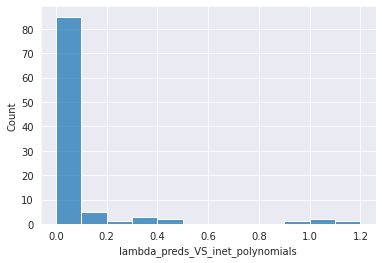

In [41]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

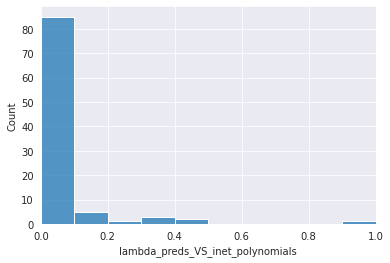

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


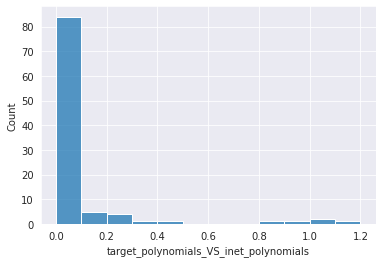

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

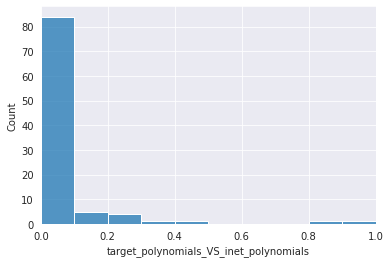

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


[(-30.0, 1.0)]

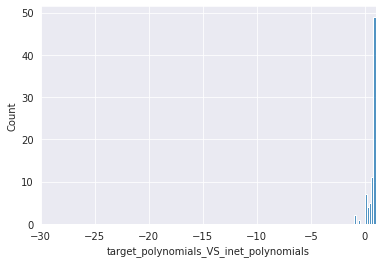

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

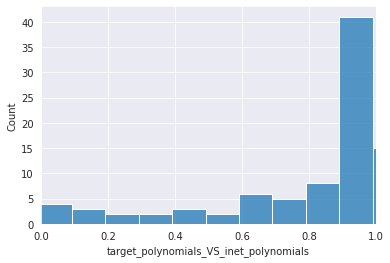

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

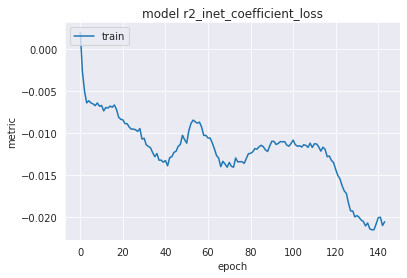

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [48]:
min(history['val_loss'])

0.08525540679693222

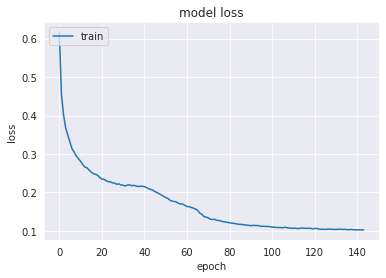

In [49]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [52]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [53]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.3885*a**3 - 0.3541*a**2 + 0.0279*a - 0.5208 + 0.0001/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.3779*a**3 - 0.3018*a**2 - 0.012*a - 0.5168

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.3779*a**3 - 0.3018*a**2 - 0.012*a - 0.5168

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.0429*a**2 - 0.0043*a - 0.5491 + 0.0036/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


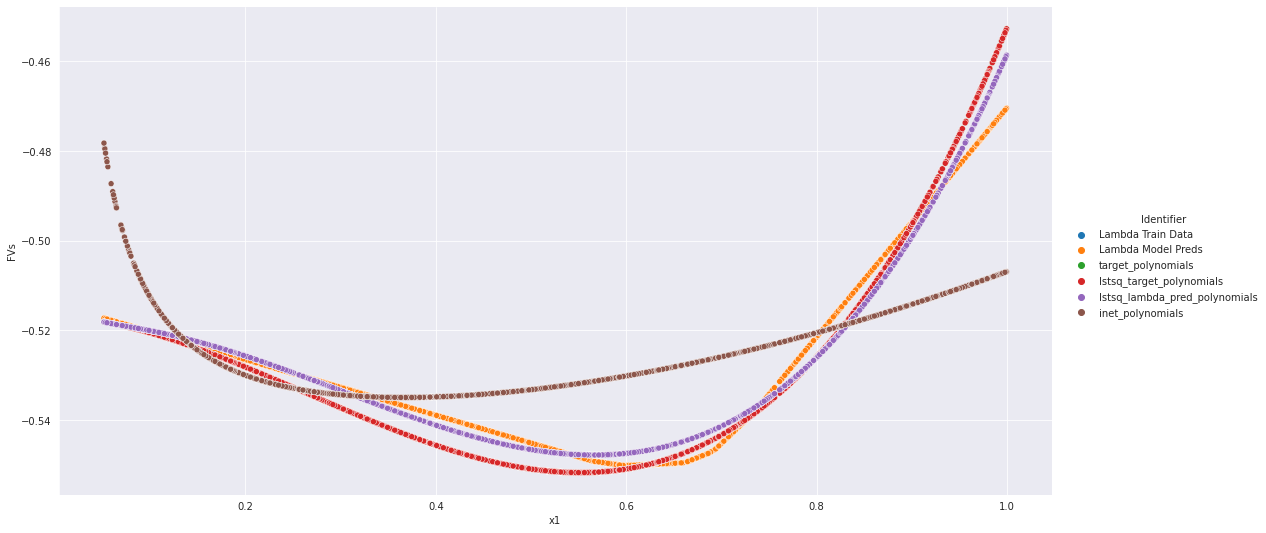

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

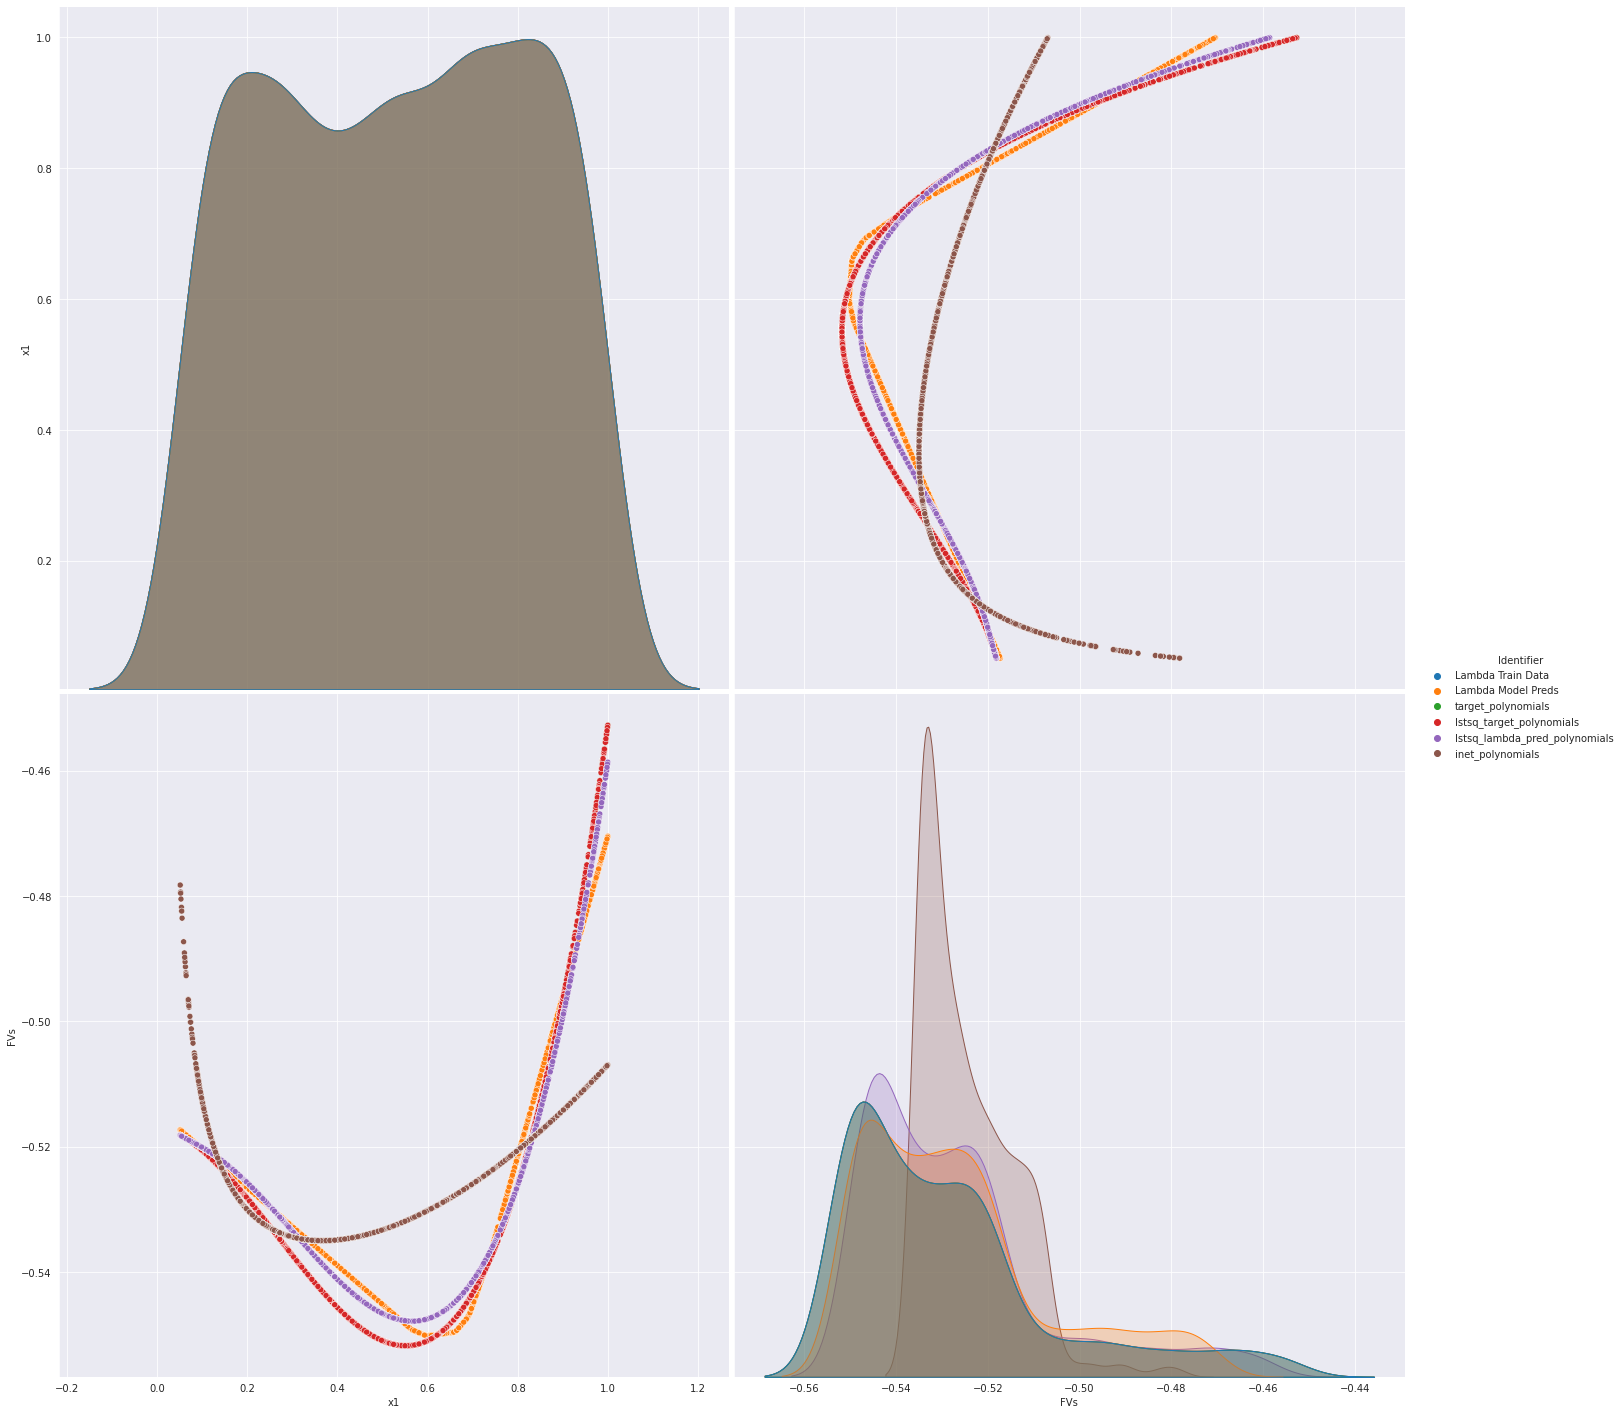

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

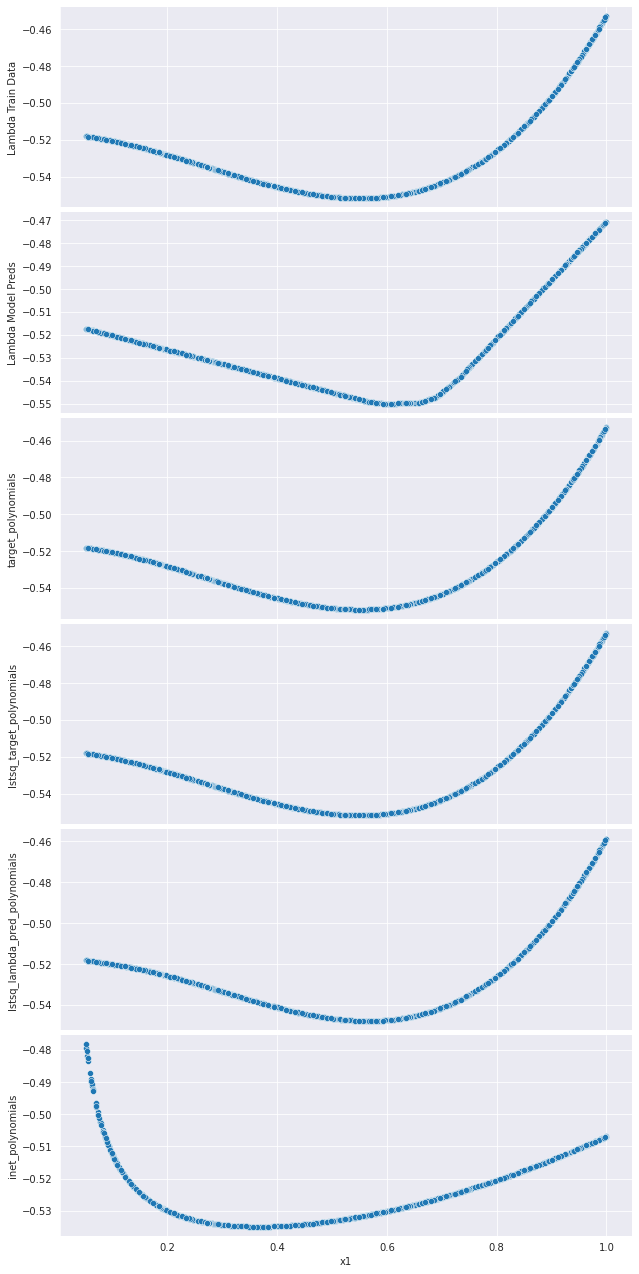

In [56]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [57]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [58]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [59]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.2213


In [60]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 18.3952


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [61]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [62]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.635


In [63]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [64]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.16939985752105713 
 Curr_res: 0.4931166172027588 
 Iteration 1, Step 27
Optimization terminated at 0.07026196271181107


array([-0.03170575, -0.33707815, -0.4643198 ,  0.07701187, -0.19721818,
        0.18209696,  0.63791955,  0.27701473,  0.04227114,  0.84219384,
        0.90637195,  0.222556  ,  0.9198462 ,  0.68789077,  0.42705178,
        0.878158  ,  0.6943959 ,  0.46567595,  0.52925766,  0.33019018,
        0.12754858,  0.16153514,  0.5085137 ,  0.44301772,  0.35205877,
        0.8969147 ,  0.24940813,  0.76328313,  0.85935795,  0.08480155],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [65]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (x_max-x_min)*(features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())+x_min

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Acceleration']] #Horsepower
    elif n == train_features_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

,Acceleration
0,0.276
1,0.248
2,0.220
3,0.276
4,0.191


In [66]:
features_autoMPG = dataset_autoMPG.copy()
labels_autoMPG = features_autoMPG.pop('MPG')+100


In [67]:
print(labels_autoMPG.min())
print(labels_autoMPG.max())

109.0
146.6


In [68]:
labels_autoMPG = (labels_autoMPG)/(labels_autoMPG.max())


In [69]:
print(labels_autoMPG.min())
print(labels_autoMPG.max())

0.7435197817189632
1.0


In [70]:
features_autoMPG = dataset_autoMPG.copy()
labels_autoMPG = features_autoMPG.pop('MPG')


In [71]:
labels_autoMPG = (labels_autoMPG)/(labels_autoMPG.max())


In [72]:
print(labels_autoMPG.min())
print(labels_autoMPG.max())

0.19313304721030042
1.0


In [73]:
#%load_ext autoreload

In [74]:
np.isinf(features_autoMPG_model.values).any()

False

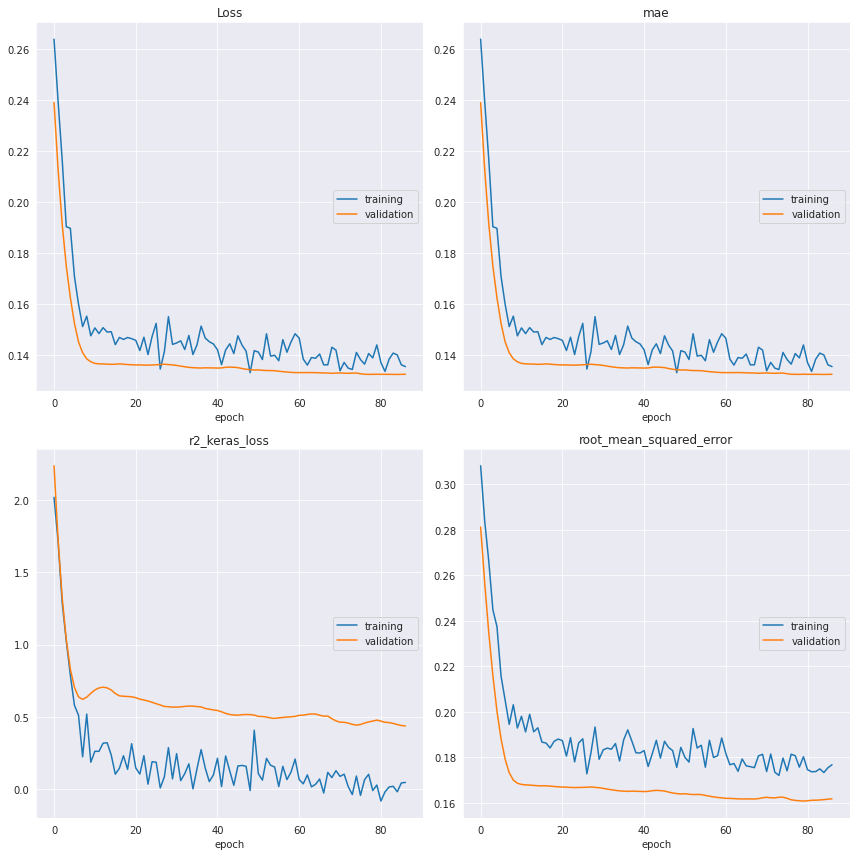

Loss
	training         	 (min:    0.133, max:    0.264, cur:    0.135)
	validation       	 (min:    0.132, max:    0.239, cur:    0.132)
mae
	training         	 (min:    0.133, max:    0.264, cur:    0.135)
	validation       	 (min:    0.132, max:    0.239, cur:    0.132)
r2_keras_loss
	training         	 (min:   -0.084, max:    2.020, cur:    0.045)
	validation       	 (min:    0.436, max:    2.239, cur:    0.436)
root_mean_squared_error
	training         	 (min:    0.172, max:    0.308, cur:    0.177)
	validation       	 (min:    0.161, max:    0.281, cur:    0.162)


In [75]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

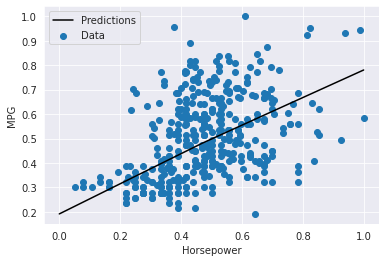

In [76]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model.values, labels_autoMPG.values, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [77]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [78]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


0.643476693293438*a**3 + 0.511660369047564*a**2 + 0.48865241561706*a + 0.56359229000568 + 0.485349136038849/a

MAE Model:  0.0007345705525880172
MAE Data:  0.11060005509595523
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [79]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, normalized=False, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


0.200874820351601*a**2 + 0.105458036065102*a + 0.163226187229156 + 0.00824369117617607/a

MAE Model:  0.20288894003428462
MAE Data:  0.20427354452586183
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [80]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 0.057203833013772964 
 Curr_res: 0.06740406900644302 
 Iteration 2, Step 62
Optimization terminated at 0.041830889880657196
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


0.641750909388065*a**2 + 0.305395323783159 - 0.000440575211541727/a

MAE Model:  0.028018179409163672
MAE Data:  0.11078951934316426
Computation Time: 0:00:08
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [81]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          2430.59        7        0.0250227        0.0288336      4.13m
   1    11.03          1.37855       15       0.00810264       0.00740761      1.92m
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Poly:


0.618*x + 0.188

MAE Model:  0.003725095247388246
MAE Data:  0.11104027210362995
Computation Time: 0:00:27
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [82]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [83]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [84]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


0.200874820351601*a**2 + 0.105458036065102*a + 0.163226187229156 + 0.00824369117617607/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


0.641750909388065*a**2 + 0.305395323783159 - 0.000440575211541727/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


0.0695156058068594*a**3 - 0.172810787655755*a**2 + 0.705005815461733*a + 0.177940558027951 + 0.000610893072982788/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


0.618*x + 0.188

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


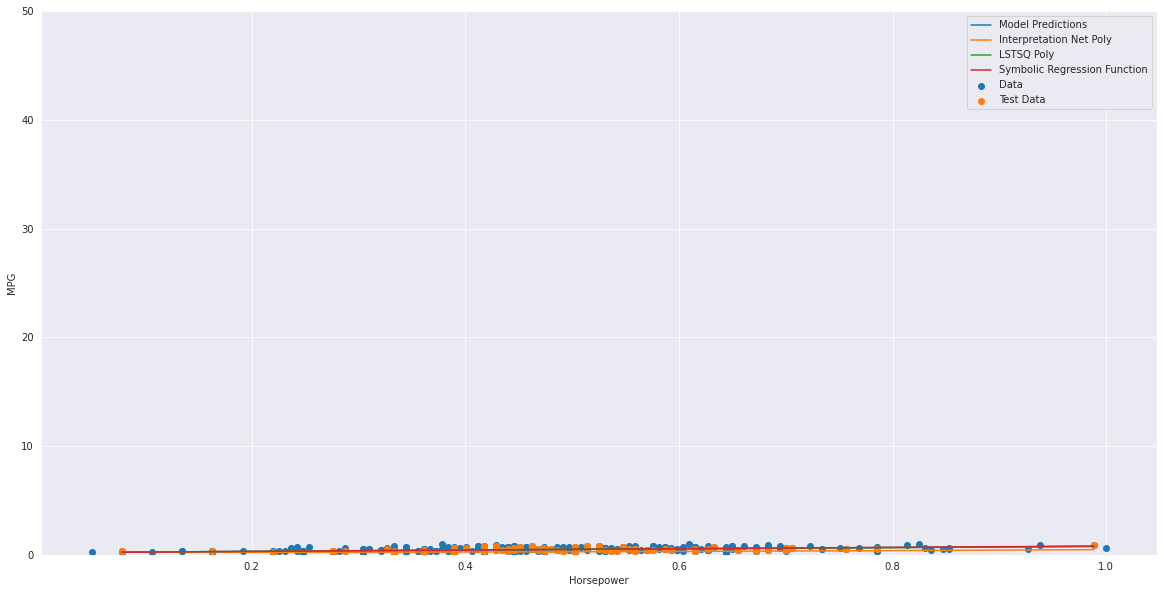

In [85]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model.values, labels_autoMPG.values, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [86]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [87]:
current_seed = 42

In [88]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [89]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

Model: "sequential_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_410 (Dense)            (None, 5)                 10        
_________________________________________________________________
dense_411 (Dense)            (None, 3)                 18        
_________________________________________________________________
dense_412 (Dense)            (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [91]:
model.get_weights()

[array([[ 1.0167775 , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
       dtype=float32),
 array([-0.16888502,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32),
 array([[ 1.562712  , -0.02688342, -0.01456122],
        [-0.42922467,  0.40037042,  0.67994815],
        [ 0.77379066,  0.4318593 , -0.26109576],
        [ 0.08172262, -0.41291407,  0.3418085 ],
        [-0.6588274 ,  0.0603506 ,  0.3722121 ]], dtype=float32),
 array([ 0.17921136,  0.        , -0.65470314], dtype=float32),
 array([[ 1.8889189 ],
        [ 0.31487274],
        [-0.6415678 ]], dtype=float32),
 array([0.16035195], dtype=float32)]

In [92]:
model.predict([1, 10])

array([[ 3.0017073],
       [30.013954 ]], dtype=float32)

In [93]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [94]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

Model: "sequential_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_413 (Dense)            (None, 5)                 10        
_________________________________________________________________
dense_414 (Dense)            (None, 3)                 18        
_________________________________________________________________
dense_415 (Dense)            (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [96]:
model.get_weights()

[array([[13.799208  , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
       dtype=float32),
 array([0.0819062, 0.       , 0.       , 0.       , 0.       ],
       dtype=float32),
 array([[14.5386095 , -0.02688342, -0.01456132],
        [-0.42922467,  0.40037042,  0.67994815],
        [ 0.77379066,  0.4318593 , -0.26109576],
        [ 0.08172262, -0.41291407,  0.3418085 ],
        [-0.6588274 ,  0.0603506 ,  0.3722121 ]], dtype=float32),
 array([-1.0085758 ,  0.        , -0.65470314], dtype=float32),
 array([[14.952865  ],
        [ 0.31487274],
        [-0.6415678 ]], dtype=float32),
 array([-2.94973], dtype=float32)]

In [97]:
model.predict([1, 10])

array([[ 2999.6382],
       [29998.408 ]], dtype=float32)

In [98]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_416 (Dense)            (None, 5)                 10        
_________________________________________________________________
dense_417 (Dense)            (None, 3)                 18        
_________________________________________________________________
dense_418 (Dense)            (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [100]:
model_2 = keras.models.clone_model(model)

model_2.summary()

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_416 (Dense)            (None, 5)                 10        
_________________________________________________________________
dense_417 (Dense)            (None, 3)                 18        
_________________________________________________________________
dense_418 (Dense)            (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.get_weights()

[array([[ 1.0263984 , -0.32123613,  0.7346986 , -0.10377216, -0.41428995]],
       dtype=float32),
 array([-0.00108473,  0.        ,  0.0154547 ,  0.        ,  0.        ],
       dtype=float32),
 array([[ 1.0745947 , -0.00384974, -0.22423065],
        [ 0.7133753 ,  0.23840302, -0.55062425],
        [ 0.8624115 , -0.3862218 , -0.7928096 ],
        [ 0.5926971 ,  0.7038569 , -0.4805471 ],
        [ 0.72719485,  0.3254363 , -0.12635005]], dtype=float32),
 array([-0.01405041,  0.        ,  0.        ], dtype=float32),
 array([[ 1.7258295 ],
        [-1.1835729 ],
        [-0.45167738]], dtype=float32),
 array([-0.00102174], dtype=float32)]

In [102]:
model.predict([1, 10])

array([[ 2.9927526],
       [29.966043 ]], dtype=float32)

In [103]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [104]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [105]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [106]:
model_2.set_weights(model_2_normalized_weights)

In [107]:
model_2.get_weights()

[array([[ 0.10263984, -0.03212361,  0.07346986, -0.01037722, -0.04142899]],
       dtype=float32),
 array([-0.00010847,  0.        ,  0.00154547,  0.        ,  0.        ],
       dtype=float32),
 array([[ 0.10745947, -0.00038497, -0.02242306],
        [ 0.07133753,  0.0238403 , -0.05506242],
        [ 0.08624115, -0.03862218, -0.07928096],
        [ 0.05926971,  0.07038569, -0.04805471],
        [ 0.07271948,  0.03254363, -0.012635  ]], dtype=float32),
 array([-0.0001405,  0.       ,  0.       ], dtype=float32),
 array([[ 0.17258295],
        [-0.11835729],
        [-0.04516774]], dtype=float32),
 array([-1.0217431e-06], dtype=float32)]

In [108]:
model_2.predict([1, 10])

array([[0.00299275],
       [0.02996604]], dtype=float32)

In [109]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

NameError: name 'plot_metric_list' is not defined

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()